In [60]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

import math
import json
import os
import wandb
from datasets import FourierDataset
from utils import hash_dict, signal_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

color_pallete = "colorblind"
sns.set_palette(color_pallete)

In [61]:
def get_model_dir(config, experiment_name):
    data_directory = os.environ.get("EXPERIMENT_DATA") if "EXPERIMENT_DATA" in os.environ else os.getcwd()

    keys_to_ignore = ["num_epochs"]
    config_to_hash = {k:v for k, v in config.items() if k not in keys_to_ignore}
    config_hash = hash_dict(config_to_hash)

    model_dir = f"{data_directory}/checkpoints/{experiment_name}/{config_hash}/"

    return model_dir

In [62]:
project_path = "whfourier/FixedSyntheticSCSingleDeg"
experiment_name = "spectrum"

criteria = {
    "n": 10,
    "d": 5,
    "dataset_size_coef": 3,
    "fix_seed": [1, 2, 3, 4, 5],
    "lr": 0.01,
    "training_method": ["normal", "EN", "EN-S", "hashing"],
}
original_b = int(math.ceil(math.log2(criteria["d"])))
hashing_discounts = [1, 2, 4]

n = criteria["n"]
k=criteria["d"]

int_freqs = {}
for fix_seed in criteria["fix_seed"]:
    dataset = FourierDataset(criteria["n"], k=k, n_samples=2**n, freq_seed=fix_seed, random_seed=criteria.get("sample_seed", 11),
                            freq_sampling_method="single_deg", amp_sampling_method="constant")
    int_freqs[fix_seed] = dataset.get_int_freqs()


Seed 1
normal 25
EN 25
EN-S 25
hashing 150
25
25
25
Seed 2
normal 25
EN 25
EN-S 25
hashing 150
25
25
25
Seed 3
normal 25
EN 25
EN-S 25
hashing 150
25
25
25
Seed 4
normal 25
EN 25
EN-S 25
hashing 150
25
25
25
Seed 5
normal 25
EN 25
EN-S 25
hashing 150
25
25
25


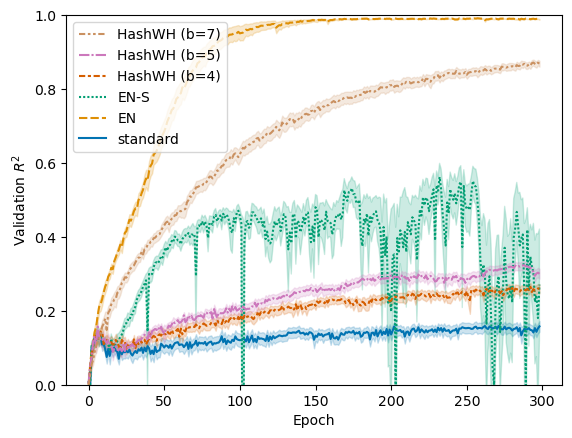

In [63]:
api = wandb.Api(timeout=60)
epoch = 499
final_epoch = 299

hadamard_lambdas = {
    1: 0.001,
    2: 0.001,
    4: 0.1
}

seeded_all_spectrums = {}
seeded_logs = {}
for fix_seed in criteria["fix_seed"]:
    print("Seed", fix_seed)
    agg_spectrums = {}
    all_spectrums = {}
    logs = {}
    for training_method in criteria["training_method"]:
        filters = {f'config.{k}': v for k, v in criteria.items()}
        filters["config.training_method"] = training_method
        filters["config.fix_seed"] = fix_seed
        # lambda
        if training_method == "EN":
            filters["config.hadamard_lambda"] = 1
        elif training_method == "alternate":
            filters["config.hadamard_lambda"] = 1
        elif training_method == "hashing":
            filters["config.hadamard_lambda"] = {"$in": list(hadamard_lambdas.values())}

        runs = api.runs(project_path, filters=filters)
        spectrum_list = []
        log_list = []
        print(training_method, len(runs))

        for run in runs:
            remove_from_train_config = ["hashing_discount", "dataset_size_coef", "val_size"]
            train_config = {k:v for k, v in run.config.items() if k not in remove_from_train_config}

            model_dir = get_model_dir(train_config, experiment_name)
            # Load Fourier Spectrums
            spectrum_file = f'{model_dir}/spectrums{epoch}.npy'
            if os.path.exists(spectrum_file):
                spectrum_list.append(np.array(np.load(spectrum_file, allow_pickle=True)))
                with open(f'{model_dir}/log{epoch}.json') as log:
                    log_list.append(json.load(log))
            else:
                raise Exception(f"{spectrum_file} not found.", train_config)
        
        # Split hashings into b-separated models
        if training_method == "hashing":
            for discount in hashing_discounts:
                indices = [i for i, run in enumerate(runs) if (run.config["hashing_discount"]==discount) and (run.config["hadamard_lambda"]==hadamard_lambdas[discount])]
                print(len(indices))
                title = f"hashing (b={original_b + discount})"
                all_spectrums[title] = [spectrum * (k / 2**(n/2)) for i, spectrum in enumerate(spectrum_list) if i in indices] 
                logs[title] = [log for i, log in enumerate(log_list) if i in indices]
        else:

            all_spectrums[training_method] = [spectrum * (k / 2**(n/2)) for spectrum in spectrum_list] 
            logs[training_method] = log_list    
    seeded_all_spectrums[fix_seed] = all_spectrums
    seeded_logs[fix_seed] = logs

# Rename methods for plotting
renames ={
    "normal": "standard",
    "hashing": "HashWH",
}

new_methods = {k:k for k in all_spectrums.keys()}
for name, replacement in renames.items():
    for method in new_methods.keys():
        new_methods[method] = new_methods[method].replace(name, replacement)

for fix_seed in criteria["fix_seed"]:
    for name, new_name in new_methods.items():
        seeded_all_spectrums[fix_seed][new_name] = seeded_all_spectrums[fix_seed].pop(name)
        seeded_logs[fix_seed][new_name] = seeded_logs[fix_seed].pop(name)

# Plot logs
data = {}
for fix_seed in criteria["fix_seed"]:
    logs = seeded_logs[fix_seed]
    for i, (method, log_list) in enumerate(logs.items()):
        data[method] = [log[epoch]["val_r2"]
                        for epoch in range(final_epoch)
                        for log in log_list]
        # all_data[method] = gaussian_filter1d(all_data[method], sigma=1)
        data["Epoch"] = [epoch
                            for epoch in range(final_epoch)
                            for log in log_list]

# g = sns.lineplot(data=data)
g = sns.lineplot(data=pd.DataFrame(data).set_index("Epoch"), errorbar="se")
g.set_xlabel("Epoch")
g.set_ylabel("Validation $R^2$")
g.set_ylim(0, 1)
# g.set_title("Performance on the synthetic dataset")
handles, labels = g.get_legend_handles_labels()
g.legend(handles[::-1], labels[::-1])
plt.savefig(f"files/spectrum/val_r2_n{criteria['n']}_d{criteria['d']}_size{criteria['dataset_size_coef']}.pdf")

## Evolution histogram

/tmp/ipykernel_3808/828435010.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.02, .9, 1])


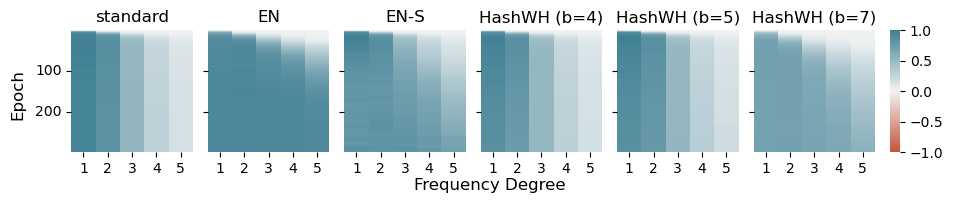

In [64]:
# ground_spectrum = dataset.get_fourier_spectrum().reshape(1, -1)

selected_spectrums = {method: [] for method in new_methods.values()}
for fix_seed in criteria["fix_seed"]:
    ind_degrees = [(np.binary_repr(i).count('1'), i) for i in int_freqs[fix_seed]]
    deg_sorted_ind = [t[1] for t in sorted(ind_degrees)]
    
    for i, (method, spectrum_list) in enumerate(seeded_all_spectrums[fix_seed].items()):
        selected_spectrums[method].extend([spectrum[:final_epoch, deg_sorted_ind] for spectrum in spectrum_list])

fig, axes = plt.subplots(1, len(selected_spectrums), figsize=(10, 2), sharey=True)
cbar_ax = fig.add_axes([.9, .215, .01, .61])

data_range = 1
cmap = sns.diverging_palette(20, 220, as_cmap=True)
for i, (method, spectrum_list) in enumerate(selected_spectrums.items()):
    sorted_degs = list(range(1, criteria["d"]+1))
    sns.heatmap(pd.DataFrame(np.mean(spectrum_list, axis=0), columns=sorted_degs), 
                cmap=cmap, vmin=-data_range, vmax=data_range, ax=axes[i], 
                cbar=False if i<len(selected_spectrums) -1 else True, cbar_ax=cbar_ax)
    axes[i].set_title(method)
    axes[i].set_xticks([i + 0.5 for i in range(len(sorted_degs))], sorted_degs)
    axes[i].set_yticks(list(range(100, final_epoch, 100)), list(range(100, final_epoch, 100)))
    # axes[i].set_xlabel("Frequency degree")
# fig.suptitle("Learned amplitudes on dataset frequencies")
fig.supylabel("Epoch")

fig.tight_layout(rect=[0, 0.02, .9, 1])
fig.supxlabel("Frequency Degree")
plt.savefig(f"files/spectrum/data_freq_heatmap_n{criteria['n']}_d{criteria['d']}_size{criteria['dataset_size_coef']}.pdf")

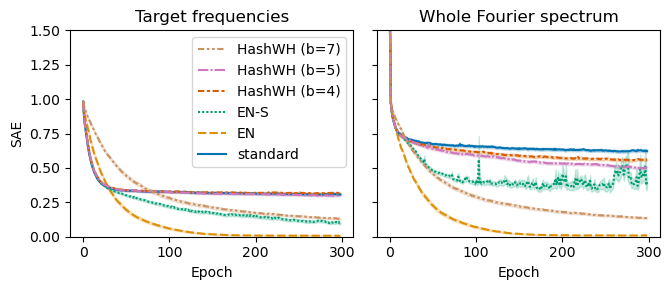

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(6.75, 3), sharey=True)
# Dataset Freqs
all_data = {method: [] for method in new_methods.values()}
all_data["Epoch"] = []
for fix_seed in criteria["fix_seed"]:
    all_spectrums = seeded_all_spectrums[fix_seed]
    for i, (method, spectrum_list) in enumerate(all_spectrums.items()):
        ground_amps  = np.ones(len(int_freqs[fix_seed]))
        all_data[method].extend(
                [signal_error(ground_amps, spectrum[epoch, int_freqs[fix_seed]]) 
                            for epoch in range(final_epoch)
                            for spectrum in spectrum_list]
        )
        # all_data[method] = gaussian_filter1d(all_data[method], sigma=1)
        if method=="standard": # just keep track of epochs once
                all_data["Epoch"].extend(
                        [epoch
                                for epoch in range(final_epoch)
                                for spectrum in spectrum_list]
                )
                        
g = sns.lineplot(data=pd.DataFrame(all_data).set_index("Epoch"), errorbar="se", ax=axes[0])
g.set_title("Target frequencies")
g.set_xlabel("Epoch")
g.set_ylabel("SAE")

# Spectrum
all_data = {method: [] for method in new_methods.values()}
all_data["Epoch"] = []
for fix_seed in criteria["fix_seed"]:
    all_spectrums = seeded_all_spectrums[fix_seed]
    ground_amps  = np.zeros(2**criteria["n"])
    ground_amps[int_freqs[fix_seed]] = 1
    for i, (method, spectrum_list) in enumerate(all_spectrums.items()):
        
        all_data[method].extend(
                [signal_error(ground_amps, spectrum[epoch]) 
                            for epoch in range(final_epoch)
                            for spectrum in spectrum_list]
        )
        # all_data[method] = gaussian_filter1d(all_data[method], sigma=1)
        if method=="standard": # just keep track of epochs once
                all_data["Epoch"].extend(
                        [epoch
                                for epoch in range(final_epoch)
                                for spectrum in spectrum_list]
                )
                        
g = sns.lineplot(data=pd.DataFrame(all_data).set_index("Epoch"), errorbar="se", ax=axes[1], legend=False)
g.set_title("Whole Fourier spectrum")
g.set_xlabel("Epoch")
g.set_ylim(0, 1.5)

# # fig.suptitle("Learned signal quality")
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1])
fig.tight_layout()
plt.savefig(f"files/spectrum/function_error_n{criteria['n']}_d{criteria['d']}_size{criteria['dataset_size_coef']}.pdf")

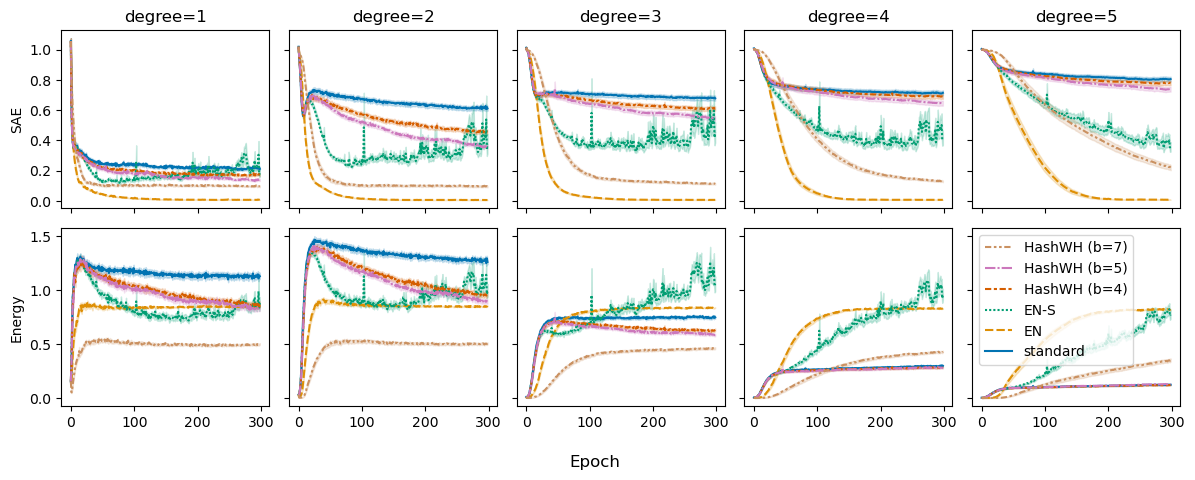

In [66]:
n_col = 5
count = criteria["d"] 
fig, axes = plt.subplots(math.ceil(count/n_col)*2, n_col, figsize=(12, math.ceil(count/n_col)*(12/n_col)*2), sharey="row", sharex=True)

degree_array = np.array([np.binary_repr(i).count('1') for i in range(2**criteria["n"])])


for d in range(1, count+1):
    indices = np.where(degree_array == d)
    all_data = {method: [] for method in new_methods.values()}
    all_data["Epoch"] = []
    for fix_seed in criteria["fix_seed"]:
        all_spectrums = seeded_all_spectrums[fix_seed]
        ground_amps  = np.zeros(2**criteria["n"])
        ground_amps[int_freqs[fix_seed]] = 1
        for j, (method, spectrum_list) in enumerate(all_spectrums.items()):
            all_data[method].extend([signal_error(ground_amps[indices], spectrum[epoch, indices]) 
                        for epoch in range(final_epoch)
                        for spectrum in spectrum_list])
            if method=="standard":
                all_data["Epoch"].extend([epoch
                                    for epoch in range(final_epoch)
                                    for spectrum in spectrum_list])

    ax = axes[0, (d-1)%n_col]
    g = sns.lineplot(data=pd.DataFrame(all_data).set_index("Epoch"), errorbar="se", ax=ax, legend=False)
    # ax.set_ylim((0, 2))
    ax.set_title(f"degree={d}")

for d in range(1, count+1):
    indices = np.where(degree_array == d)
    all_data = {method: [] for method in new_methods.values()}
    all_data["Epoch"] = []
    for fix_seed in criteria["fix_seed"]:
        all_spectrums = seeded_all_spectrums[fix_seed]
        for j, (method, spectrum_list) in enumerate(all_spectrums.items()):
            all_data[method].extend([np.sum(spectrum[epoch, indices] ** 2)
                        for epoch in range(final_epoch)
                        for spectrum in spectrum_list])
            if method=="standard":
                all_data["Epoch"].extend([epoch
                                    for epoch in range(final_epoch)
                                    for spectrum in spectrum_list])

    ax = axes[1, (d-1)%n_col]
    g = sns.lineplot(data=pd.DataFrame(all_data).set_index("Epoch"), errorbar="se", ax=ax, legend=False if d != count else True)
    # ax.set_ylim((0, 2))
    ax.set_xlabel(None)
    # ax.set_title(f"degree={d}")

axes[0, 0].set_ylabel("SAE")
axes[1, 0].set_ylabel("Energy")
# fig.legend(handles, labels, loc='upper center')
# fig.suptitle("Learned signal (splitted by degree)")
handles, labels = axes[1, 4].get_legend_handles_labels()
axes[1, 4].legend(handles[::-1], labels[::-1])
fig.supxlabel("Epoch")
fig.tight_layout()
plt.savefig(f"files/spectrum/degree_split_function_error_n{criteria['n']}_d{criteria['d']}_size{criteria['dataset_size_coef']}.pdf")

/tmp/ipykernel_3808/1250171692.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


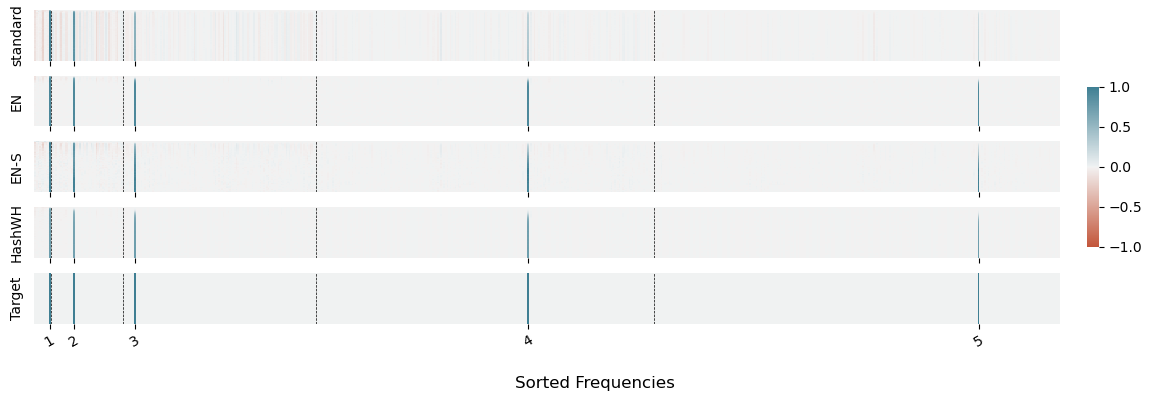

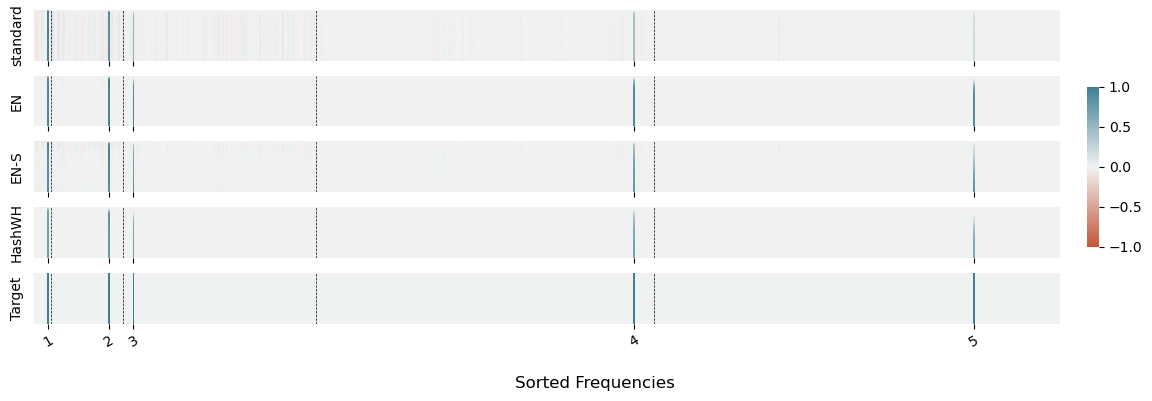

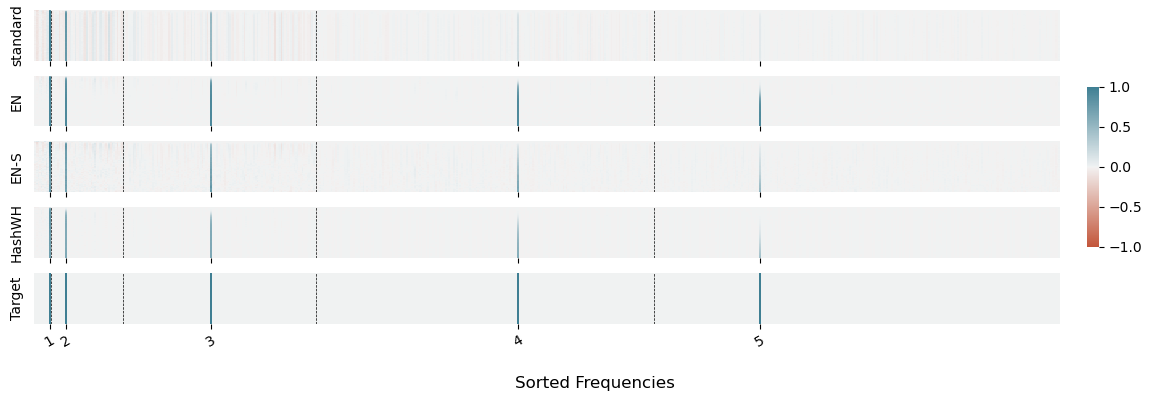

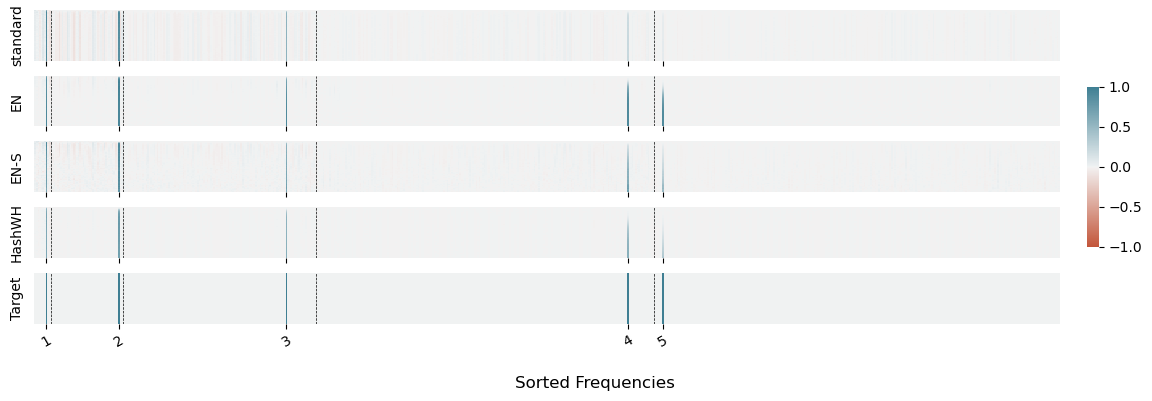

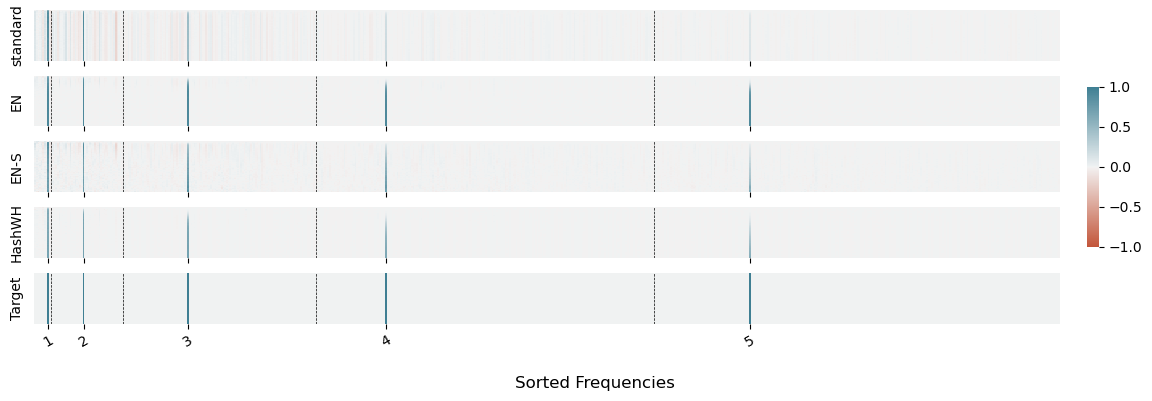

In [67]:
methods = ["standard", "EN", "EN-S", "HashWH"]
degree_array = np.array([np.binary_repr(i).count('1') for i in range(2**criteria["n"])])
cmap = sns.diverging_palette(20, 220, as_cmap=True)
selected_indices = []
seps = []
for d in range(1, criteria["d"]+1):
    selected_indices.extend(np.where(degree_array == d)[0])
    seps.append(len(selected_indices))

for fix_seed in criteria["fix_seed"]:
    all_spectrums = seeded_all_spectrums[fix_seed]
    all_spectrums["HashWH"] = all_spectrums["HashWH (b=7)"]
    agg_spectrums = {method: np.mean(all_spectrums[method], axis=0) for method in methods}
    ground_amps  = np.zeros(2**criteria["n"])
    ground_amps[int_freqs[fix_seed]] = 1

    # Plot
    fig, axes = plt.subplots(len(agg_spectrums)+1, 1, figsize=(12, len(agg_spectrums)*1), sharex=True)

    data_range = 1
    cbar_ax = fig.add_axes([.91, .37, .01, .4])
    for i, (method, spectrum) in enumerate(agg_spectrums.items()):
        sns.heatmap(spectrum[:final_epoch, selected_indices], 
                    cmap=cmap, vmin=-data_range, vmax=data_range, ax=axes[i], 
                    cbar=True if i==0 else False, cbar_ax=cbar_ax)
        if method == "HashWH":
            axes[i].set_ylabel("HashWH")
        else:
            axes[i].set_ylabel(method)

    # GT
    sns.heatmap(ground_amps[selected_indices].reshape(1, -1), cmap=cmap, vmin=-data_range, vmax=data_range, ax=axes[-1], cbar=False)
    axes[-1].set_ylabel("Target")

    # Ticks
    freq_degrees = [np.binary_repr(i).count('1') for i in int_freqs[fix_seed]]
    sorted_index = [selected_indices.index(i) + 0.5 for i in int_freqs[fix_seed]]
    for ax in axes:
        ax.set_xticks(sorted_index, freq_degrees, rotation=30)
        ax.set_yticks([])

        # Deviders
        ax.vlines(seps[:-1], *ax.get_ylim(), colors='black' , ls='--', lw=0.5)

    # fig.suptitle("Fourier spectrum convergence")
    fig.supxlabel("Sorted Frequencies")
    # axes[-1].set_xlabel("Sorted frequencies")
    fig.tight_layout(rect=[0, 0, .9, 1])
    # plt.savefig(f"files/synthetic/sc_heatmap_n{criteria['n']}_d{criteria['d']}_size{criteria['dataset_size_coef']}_seed{fix_seed}.pdf")
    plt.savefig(f"files/spectrum/sc_heatmap_n{criteria['n']}_d{criteria['d']}_size{criteria['dataset_size_coef']}_seed{fix_seed}.png", dpi=1200)